In [1]:
## Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from dateutil.parser import parse
import datetime as dt

In [2]:
## Define paths
DATA_FOLDER = './liar_dataset/'
DATA_PATH = DATA_FOLDER + 'train.tsv'

In [3]:
## Load raw data
cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
df_raw = pd.read_table(DATA_PATH, header=None)
df_raw.columns = cols
df_raw.head()

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [4]:
## Check types and shape
print(df_raw.dtypes)
print(df_raw.shape)

ID                    object
label                 object
statement             object
subject               object
speaker               object
job                   object
state                 object
party                 object
barely_true_cts      float64
false_cts            float64
half_true_cts        float64
mostly_true_cts      float64
pants_on_fire_cts    float64
context               object
dtype: object
(10240, 14)


In [5]:
## Help put data in useful form - split topics as list and separate into new rows for grouping
## Split subjects into lists
subject_split = df_raw.copy()
subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
subject_split.head()

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,[health-care],blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
## Create a dataframe of all subjects
subjects = subject_split.subject.apply(pd.Series)
new_cols = cols.copy()
new_cols.remove("subject")

## Now merge with original frame to create separate columns for each subject
## Then melt so that each entry exists under several subjects
subject_split = subjects.merge(subject_split, right_index = True, left_index = True) \
    .drop(["subject"], axis = 1) \
    .melt(id_vars = new_cols, value_name = "subject") \
    .drop("variable", axis = 1) \
    .dropna()

subject_split.head()

,ID,label,statement,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,subject
0,2635.json,false,Says the Annies List political group supports ...,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,abortion
1,10540.json,half-true,When did the decline of coal start? It started...,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,energy
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,foreign-policy
5,12465.json,true,The Chicago Bears have had more starting quart...,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,education
7,153.json,half-true,I'm the only person on this stage who has work...,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",ethics


In [15]:
breakdown = subject_split.groupby(["subject","label"]).agg({"ID" : "count"})
breakdown

ID
subject           label          
10-news-tampa-bay barely-true   1
                  half-true     1
abc-news-week     barely-true   5
                  false        12
                  half-true    15
                  mostly-true  17
                  true         11
abortion          barely-true  30
                  false        23
                  half-true    31
                  mostly-true  20
                  pants-fire   10
                  true         27
afghanistan       barely-true   2
                  false         8
                  half-true     6
                  mostly-true   7
                  pants-fire    1
                  true         10
agriculture       barely-true   7
                  false         7
                  half-true    12
                  mostly-true   7
                  pants-fire    4
                  true          6
alcohol           barely-true   7
                  false         3
                  mostly-true   1
                  pants-fire    1
                  true          5
...                            ..
water             pants-fire    1
                  true          2
wealth            barely-true   7
                  false         7
                  half-true     9
                  mostly-true  14
                  true          9
weather           barely-true   6
                  false         4
                  half-true     6
                  mostly-true   5
                  true          5
welfare           barely-true   2
                  false         6
                  half-true     2
                  mostly-true  13
                  pants-fire    2
                  true          4
women             barely-true  30
                  false        14
                  half-true    25
                  mostly-true  26
                  pants-fire    8
                  true         22
workers           barely-true  42
                  false        20
                  half-true    42
                  mostly-true  54
                  pants-fire    5
                  true         30

[758 rows x 1 columns]

In [20]:
breakdown.index.levels[0]

Index(['10-news-tampa-bay', 'abc-news-week', 'abortion', 'afghanistan',
       'agriculture', 'alcohol', 'animals', 'bankruptcy', 'baseball',
       'bipartisanship',
       ...
       'unions', 'urban', 'veterans', 'voting-record', 'water', 'wealth',
       'weather', 'welfare', 'women', 'workers'],
      dtype='object', name='subject', length=139)

In [28]:
a = breakdown.reset_index()
a.head()

,subject,label,ID
0,10-news-tampa-bay,barely-true,1
1,10-news-tampa-bay,half-true,1
2,abc-news-week,barely-true,5
3,abc-news-week,false,12
4,abc-news-week,half-true,15


In [29]:
totals = a.groupby(a["subject"]).agg({"ID" : "sum"})
falses = a.where(a["label"]=="false").groupby(a["subject"]).agg({"ID" : "sum"})

In [41]:
subjects = totals.index
percent_falses = np.array(falses.values)/np.array(totals.values)


In [54]:
# pd.DataFrame(np.c_[np.array(subjects), percent_falses])
percent_falses = pd.DataFrame(np.array(falses.values)/np.array(totals.values))
percent_falses.index = subjects
percent_falses.columns = ["Percentage as Lies"]
percent_falses.head()

,Percentage as Lies
subject,
10-news-tampa-bay,0.000000
abc-news-week,0.200000
abortion,0.163121
afghanistan,0.235294
agriculture,0.162791


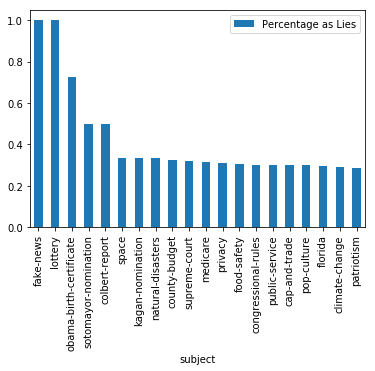

In [63]:
percent_falses.sort_values("Percentage as Lies", ascending=False, inplace=True)
percent_falses.head(20).plot(kind="bar")